# Question Answering Engine

## 03: Span Entity & Relation Prediction BERT-based Models

After the experiments with a single question-answering model for both span entity recognition and relation prediction, I discovered that this approach was not as effective as I had hoped. Relation extraction is a more complex task than entity recognition and trying to learn both tasks simultaneously proved challenging for the model and it was only able to perform well on the span entity task. 

In response, I decided to take a different approach, using separate span entity and relation prediction models. By using this approach I saw immediately good results. The two models were able to learn and perform great in unseen data in both entity and relation prediction respectively. This notebook presents the results of my best experiments with this approach.

### Libraries

Initially importing the necessary libraries.

In [2]:
# Pytorch
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset

# Numpy, Plotting, Metrics
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import time
import random

from unidecode import unidecode

# Testing and metrics
from sklearn.metrics import roc_curve, roc_auc_score, f1_score, precision_score, recall_score, confusion_matrix, precision_recall_fscore_support

# BERT
from transformers import BertTokenizer, BertModel, get_linear_schedule_with_warmup, logging
logging.set_verbosity_error()

# Metal to run it locally on apple silicon, it falls back to CUDA online, else CPU as final resort
device = 'mps' if (torch.backends.mps.is_available()) else 'cuda' if ( torch.cuda.is_available()) else 'cpu'

### Datasets

Reading with pandas the data from the CSV files to create train, validation, and test datasets. Also creating the relation vocabulary to create a list of possible relations.

In [4]:
# Firstly read the dictionary I created
df = pd.read_csv("dataset/entity_dict.csv", sep = ',')
Entities = df['Entity']
Entity_ids = df['Id']

# Remove accents from the 'Entity' column
df['Entity'] = df['Entity'].apply(lambda x: unidecode(x))

# Then read the relations
df = pd.read_csv("dataset/relation_vocab.csv")

# Create a list with the relation vocabulary
relation_vocab = df['Relation'].to_list()

# Finally read the train dataset
df = pd.read_csv("dataset/train_dataset.csv", sep = ',')
train_Questions = df['question']
train_Entity_ids = df['entity_id']
train_Entity_labels = df['entity_label']
train_Entity_start = df['entity_start']
train_Entity_end = df['entity_end']
train_Relation_ids = df['relation_id']
train_Answer_ids = df['answer_id']

# Validation dataset
df = pd.read_csv("dataset/val_dataset.csv", sep = ',')
val_Questions = df['question']
val_Entity_ids = df['entity_id']
val_Entity_labels = df['entity_label']
val_Entity_start = df['entity_start']
val_Entity_end = df['entity_end']
val_Relation_ids = df['relation_id']
val_Answer_ids = df['answer_id']

# Test dataset
df = pd.read_csv("dataset/test_dataset.csv", sep = ',')
test_Questions = df['question']
test_Entity_ids = df['entity_id']
test_Entity_labels = df['entity_label']
test_Entity_start = df['entity_start']
test_Entity_end = df['entity_end']
test_Relation_ids = df['relation_id']
test_Answer_ids = df['answer_id']

# Free the dataframe's memory resources
del df

Loading the BERT tokenizer from the pre-trained "bert-base-uncased" model.

In [5]:
# Load the BERT tokenizer
BERT_MODEL = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(BERT_MODEL, do_lower_case=True)

### Functions & Model

Seeding function for reproducibility.

In [ ]:
def seedTorch(seed=33):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    os.environ['PYTHONHASHSEED'] = str(seed)

For preprocessing since the span start and end correspond to actual words, with the BERT tokenizer I need to locate the corresponding start and end tokens in the BERT tokenized question for each entity. The function returns the tokenized input IDs, attention masks, and the start and end token positions for each question as PyTorch tensors.

In [6]:
# Returns input_ids, attention_masks, start, ends for BERT
def preprocess(questions, max_length, entity_starts, entity_ends):

    ids = []
    masks = []
    token_starts = []
    token_ends = []
    
    for i, question in enumerate(questions):

        # Not replacing ? and 's here since these might be helpful 
        question = unidecode(question.replace("?", "").replace("'s", ""))
        question_t = question.split()

        # Locate the corresponding start in the BERT tokenized question
        start_token = tokenizer.encode_plus(
            text = question_t[entity_starts[i]],
            return_attention_mask=True,
            add_special_tokens=False
        ) 
        start_token = start_token['input_ids'][0]

        # Locate the corresponding end in the BERT tokenized question
        end_token = tokenizer.encode_plus(
            text = question_t[entity_ends[i]],
            return_attention_mask=True,
            add_special_tokens=False
        ) 
        end_token = end_token['input_ids'][-1]

        # Encode the question
        encoding = tokenizer.encode_plus(
            text = question,
            max_length=max_length,
            truncation=True,
            pad_to_max_length=True,
            return_attention_mask=True,
            padding='max_length',
            add_special_tokens=False
        ) 
        tokens = encoding['input_ids']
        
        # Append in the corresponding lists
        ids.append(tokens)
        masks.append(encoding['attention_mask'])
        token_starts.append(tokens.index(start_token))
        token_ends.append(tokens.index(end_token))

    return torch.tensor(ids), torch.tensor(masks), token_starts, token_ends

Custom dataset class that preprocesses the questions using the function I defined above. It keeps the input_ids, attention_masks, entity start and end token positions, and relation IDs for each question as PyTorch tensors.

In [7]:
# A custom Question Dataset class to use for the dataloaders
class QuestionDataset(Dataset):

    def __init__(self, questions, entity_start, entity_end, relation_ids, length):
        ids, masks, entity_start_T, entity_end_T = preprocess(questions, length, entity_start, entity_end)
        self.max_length = length
        self.input_ids = ids
        self.attention_masks = masks 
        self.entity_start = torch.tensor(entity_start_T, dtype=torch.long)
        self.entity_end = torch.tensor(entity_end_T, dtype=torch.long)
        self.relation_ids = torch.tensor([relation_vocab.index(r) for r in relation_ids.to_list() ])
        self.samples = len(relation_ids)

    def __len__(self):
        return self.samples

    def __getitem__(self, idx):
        return {'input_ids': self.input_ids[idx], 
                'attention_mask': self.attention_masks[idx],
                'entity_start': self.entity_start[idx],
                'entity_end': self.entity_end[idx],
                'relation_ids': self.relation_ids[idx]
                }

Since the maximum length is 34 a maximum sequence length of 36 tokens would be enough. Also I select a batch size of 32 which worked well so far with BERT (with a larger batch size in my local machine it was unable to run). I create the three datasets for the training, validation and testing data and the corresponding dataloaders.

In [8]:
MAX_LENGTH = 36
BATCH_SIZE = 32

# Tokenizing, preprocessing and dataset creation
train_dataset = QuestionDataset(train_Questions, train_Entity_start, train_Entity_end, train_Relation_ids, MAX_LENGTH)
val_dataset = QuestionDataset(val_Questions, val_Entity_start, val_Entity_end, val_Relation_ids, MAX_LENGTH)
test_dataset = QuestionDataset(test_Questions, test_Entity_start, test_Entity_end, test_Relation_ids, MAX_LENGTH)

# Corresponding Dataloaders
train_dataloader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
val_dataloader = DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
test_dataloader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

Then I define the BERT_SPAN model for span entity that outputs predictions for the start and end positions of entities in a given input sequence. The BERT model generates a sequence output, which is then passed through two separate linear layers and softmax functions to generate the start and end predictions. The final output is the element-wise product of these predictions and the input attention mask.

In [9]:
class BERT_SPAN(torch.nn.Module):
    def __init__(self, bert_model, vocab_size):
        super().__init__()
        self.bert = BertModel.from_pretrained(bert_model)

        self.start_head = nn.Sequential(
            nn.Dropout(p=0.15),
            nn.Linear(self.bert.config.hidden_size, 1),
            nn.Flatten(),
            nn.Softmax(dim=1)
        )

        self.end_head = nn.Sequential(
            nn.Dropout(p=0.15),
            nn.Linear(self.bert.config.hidden_size, 1),
            nn.Flatten(),
            nn.Softmax(dim=1)
        )
        
        self.vocab_size = vocab_size

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids, attention_mask=attention_mask)
        sequence_output = outputs[0]
        
        start_ent = self.start_head(sequence_output)
        end_ent = self.end_head(sequence_output)
        
        return start_ent * attention_mask, end_ent * attention_mask

Similarly, the BERT_REL is an implementationg of the relation prediction model. The class takes in a BERT model and vocabulary size as inputs, and output predictions for the relations between entities in a given input sequence. The function uses the BERT model to generate an output, which is then passed through a linear layer and a softmax function to generate the relation probabilities.

In [10]:
class BERT_REL(torch.nn.Module):
    def __init__(self, bert_model, vocab_size):
        super().__init__()
        self.bert = BertModel.from_pretrained(bert_model)

        self.relation_head = nn.Sequential(
            nn.Dropout(0.15),
            nn.Linear(self.bert.config.hidden_size, vocab_size),
            nn.Softmax(dim=1)
        ) 
        self.vocab_size = vocab_size

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids, attention_mask=attention_mask)        
        return  self.relation_head(outputs[1])

#### Functions for Span Entity Model Training

Below I have the training functions for the span entity model. 
- `train_epoch_span` trains the model for one epoch and returns the mean loss. 
- `train_model_span` trains the model for a given number of epochs and returns the trained model.
- `optimize_model_span` trains the model for a given number of epochs and returns the trained model that has the best F1 score on the validation dataset. The patience is used for early stopping.
- `evaluation_function_span` evaluates the model on a given dataset and prints the metrics.

In [27]:
# Function to train for one epoch the span model
def train_epoch_span(optimizer, scheduler, dataloader, lossfunc, model, device, display=True, clip_value=0.6):

    model = model.train()
    losses = []

    # For each batch
    for batch, data in enumerate(dataloader):

        # In case the GPU is used
        ids = data['input_ids'].to(device)
        mask = data['attention_mask'].to(device)

        # The actual entity and relations
        actual_entity_starts = data['entity_start'].to(device)
        actual_entity_ends = data['entity_end'].to(device)
        
        # Predict and calculate loss
        start_logits, end_logits  = model(input_ids=ids, attention_mask=mask)

        # Find the start and end indices with the highest probability
        start_preds = torch.argmax(start_logits, dim=1)

        # Create a mask with the same shape as the matrix
        start_mask = torch.zeros((len(start_preds), MAX_LENGTH)).to(device)

        # Set the ones in the mask based on the indices in the tensor
        for i, idx in enumerate(start_preds):
            start_mask[i, idx:] = 1

        masked_end_logits = end_logits * start_mask
        span_loss1 = lossfunc(start_logits, actual_entity_starts)
        span_loss2 = lossfunc(masked_end_logits, actual_entity_ends)

        total_loss = span_loss1 + span_loss2
        losses.append(total_loss.item())

        # Inform the weights
        total_loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), clip_value)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

        # When display is set print every 64 the loss
        if(display):
            if batch % 64 == 0:
                size = len(dataloader.dataset)
                loss, current = total_loss.item(), batch * len(ids)
                print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

    # Return the total mean loss
    meanloss = 0
    if len(losses)!=0:
        meanloss = sum(losses)/len(losses)
    return meanloss
 
# Function to train a model
def train_model_span(epochs, optimizer, scheduler, dataloader, entropy_loss, model, device, display=True, clip_value=0.6):

    # For each epoch
    for epoch in range(epochs):
        if (display):
            print(f"\nEpoch {epoch+1}\n_________________________________")
        train_epoch_span(optimizer, scheduler, dataloader, entropy_loss, model, device, display, clip_value)
        if (display):
            print("_________________________________")
        
    # Returns the model
    return model

# Function to train a model
def optimize_model_span(epochs, optimizer, scheduler, dataloader, val_dataloader, lossfunc, model, device, display=True, clip_value=0.6, patience = 1):

    # To find optimal model
    best_f1 = 0

    # For early stopping
    patience_count = 0
    train_losses = []
    valid_losses = []

    # For each epoch
    for epoch in range(epochs):
        if (display):
            print(f"\nEpoch {epoch+1}\n_________________________________")
        mean_train = train_epoch_span(optimizer, scheduler, dataloader, lossfunc, model, device, display, clip_value)
        _, f1_score, _, mean_val = evaluation_function_span(val_dataloader, model, lossfunc, device, True)

        train_losses.append(mean_train)
        valid_losses.append(mean_val)
        
        # If F1-score is better in the validation set then keep this model
        if (best_f1 < f1_score):

            # reset the patience count
            patience_count = 0
            
            # switch the best score
            best_f1=f1_score
            
            # Save the model
            torch.save(model.state_dict(), './best_span_model.pt')
        else:
            patience_count += 1

        if (display):
            print("_________________________________")

        # To early stop
        if patience_count == patience:
            break

    x = list(range(0, len(train_losses)))
    plt.style.use("seaborn-v0_8")
    plt.plot(x, train_losses, linestyle="-", label="Training")
    plt.plot(x, valid_losses, linestyle="-", label="Validation")
    plt.legend()
    plt.show()

    # Returns the model
    return model


# Evaluation function
def evaluation_function_span(dataloader, model, lossfunc, device, display=True):

    # Metrics initialisation
    losses = []
    total_f1_score = 0
    total_accuracy = 0 
    total_precision = 0 
    total_recall = 0 
    total_count = 0

    # So the model is in eval mode
    model.eval()
    with torch.no_grad():

        # For each batch
        for batch, data in enumerate(dataloader):

            # In case the GPU is used
            ids = data['input_ids'].to(device)
            mask = data['attention_mask'].to(device)

            # The actual positions
            actual_entity_starts = data['entity_start'].to(device)
            actual_entity_ends = data['entity_end'].to(device)

            # Predict
            start_logits, end_logits = model(input_ids=ids, attention_mask=mask)
        
            # Find the start and end indices with the highest probability
            start_preds = torch.argmax(start_logits, dim=1)

            # Create a mask with the same shape as the matrix
            start_mask = torch.zeros((len(start_preds), MAX_LENGTH)).to(device)

            # # Set the ones in the mask based on the indices in the tensor
            for i, idx in enumerate(start_preds):
                start_mask[i, idx:] = 1

            masked_end_logits = end_logits * start_mask
            end_preds = torch.argmax(masked_end_logits, dim=1)

            span_loss1 = lossfunc(start_logits, actual_entity_starts)
            span_loss2 = lossfunc(masked_end_logits, actual_entity_ends)

            total_loss = span_loss1 + span_loss2
            losses.append(total_loss.item())

            predicted_spans = [(start_preds[i].item(), end_preds[i].item(), None) for i in range(len(start_preds))]
            true_spans = [(actual_entity_starts[i].item(), actual_entity_ends[i].item(), None) for i in range(len(actual_entity_starts))]

            # These to compute the TP, FP, and FN counts for each span
            tp = 0
            fp = 0
            fn = 0

            for j in range(len(start_preds)):
                # create range objects
                true_range = range(int(true_spans[j][0]), int(true_spans[j][1]+1))
                pred_range = range(int(predicted_spans[j][0]), int(predicted_spans[j][1]+1))

                # # Compute the overlap between the predicted and true ranges
                overlap = set(true_range).intersection(set(pred_range))

                # Update the TP, FP, and FN counts
                if len(overlap) > 0:
                    tp += 1
                    fp += len(pred_range) - len(overlap)
                    fn += len(true_range) - len(overlap)
                else:
                    fp += len(pred_range)
                    fn += len(true_range)

            # Compute the precision, recall
            precision = float(tp) / float(tp + fp)
            recall = float(tp) / float(tp + fn)
            
            # Add to the total metrics
            total_f1_score += float(2 * precision * recall) / float(precision + recall)
            total_accuracy += float(tp) / float(tp + fp + fn)
            total_precision += precision
            total_recall += recall
            total_count +=1

    accuracy_entity_span = float(total_accuracy) / float(total_count) * 100
    f1_score = float(total_f1_score) / float(total_count) * 100
    dataset_wide_f1 = float(2 * total_precision * total_recall) / float(total_precision + total_recall)
    f1_star = float(dataset_wide_f1)/ float(total_count) * 100
    mean_loss = sum(losses)/len(losses)
    precision_score = float(total_precision) / float(total_count) * 100
    recall_score = float(total_recall) / float(total_count) * 100

    # Printing them if display is not false
    if display:
        print("\nEvaluation Results")
        print("_________________________________")
        print(
            f"\nMean Loss: {mean_loss:.2f} "
            f"\nPrecision: {precision_score:.2f}%"
            f"\nRecall: {recall_score:.2f}%"
            f"\nSpan Entity Accuracy : {accuracy_entity_span:.2f}%"
            f"\nAverage F1-Score: {f1_score:.2f}%"
            f"\nDataset Wide F1*: {f1_star:.2f}%"
            )
        print("_________________________________")

    # Reset the model to train mode
    model.train()

    return accuracy_entity_span, f1_score, f1_star, mean_loss


#### Functions for Relation Model Training

Below I have the training functions for the relation model. 
- `train_epoch_relation` trains the model for one epoch and returns the mean loss. 
- `train_model_relation` trains the model for a given number of epochs and returns the trained model.
- `optimize_model_relation` trains the model for a given number of epochs and returns the trained model that has the best F1 score on the validation dataset.
- `evaluation_function_relation` evaluates the model on a given dataset and prints the metrics.

In [19]:
# Function to train for one epoch the Relation Prediction model
def train_epoch_relation(optimizer, scheduler, dataloader, lossfunc, model, device, display=True, clip_value=0.6):

    model = model.train()
    losses = []

    # For each batch
    for batch, data in enumerate(dataloader):

        # In case the GPU is used
        ids = data['input_ids'].to(device)
        mask = data['attention_mask'].to(device)

        # The actual relations
        actual_relations = data['relation_ids'].to(device)
        
        # Predict and calculate loss
        relation_logits  = model(input_ids=ids, attention_mask=mask)
        total_loss = lossfunc(relation_logits, actual_relations)
        losses.append(total_loss.item())

        # Inform the weights
        total_loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), clip_value)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

        # When display is set print every 64 the loss
        if(display):
            if batch % 64 == 0:
                size = len(dataloader.dataset)
                loss, current = total_loss.item(), batch * len(ids)
                print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

    # Return the total mean loss
    meanloss = 0
    if len(losses)!=0:
        meanloss = sum(losses)/len(losses)
    return meanloss
 
# Function to train a model
def train_model_relation(epochs, optimizer, scheduler, dataloader, entropy_loss, model, device, display=True, clip_value=0.6):

    # For each epoch
    for epoch in range(epochs):
        if (display):
            print(f"\nEpoch {epoch+1}\n_________________________________")
        train_epoch_relation(optimizer, scheduler, dataloader, entropy_loss, model, device, display, clip_value)
        if (display):
            print("_________________________________")
        
    # Returns the model
    return model

# Function to train a model and find optimal relation model
def optimize_model_relation(epochs, optimizer, scheduler, dataloader, val_dataloader, lossfunc, model, device, display=True, clip_value=0.6, patience =1):

    # To find optimal model
    best_accuracy = 0

    # For early stopping
    patience_count = 0
    train_losses = []
    valid_losses = []

    # For each epoch
    for epoch in range(epochs):
        if (display):
            print(f"\nEpoch {epoch+1}\n_________________________________")
        mean_train = train_epoch_relation(optimizer, scheduler, dataloader, lossfunc, model, device, display, clip_value)
        accuracy, mean_val = evaluation_function_relation(val_dataloader, model, lossfunc, device, True)

        train_losses.append(mean_train)
        valid_losses.append(mean_val)
        
        # If accuracy is better in the validation set
        if (accuracy>best_accuracy):

            # reset the patience count
            patience_count = 0
            
            # switch the best score
            accuracy=best_accuracy
            
            # Save the model
            torch.save(model.state_dict(), './best_relation_model.pt')
        else:
            patience_count += 1

        if (display):
            print("_________________________________")

        # To early stop
        if patience_count == patience:
            break

    x = list(range(0, len(train_losses)))
    plt.style.use("seaborn-v0_8")
    plt.plot(x, train_losses, linestyle="-", label="Training")
    plt.plot(x, valid_losses, linestyle="-", label="Validation")
    plt.legend()
    plt.show()

    # Returns the model
    return model


# Evaluation function
def evaluation_function_relation(dataloader, model, lossfunc, device, display=True):

    # Metrics initialisation
    losses = []
    total_relations = 0
    correct_relations =0

    # So the model is in eval mode
    model.eval()
    with torch.no_grad():

        # For each batch
        for batch, data in enumerate(dataloader):

            # In case the GPU is used
            ids = data['input_ids'].to(device)
            mask = data['attention_mask'].to(device)
            actual_relations = data['relation_ids'].to(device)

            # Predict
            relation_logits = model(input_ids=ids, attention_mask=mask)
            total_loss = lossfunc(relation_logits, actual_relations)
            losses.append(total_loss.item())

            # Predictions of relation
            _ , predictions = torch.max(relation_logits, dim=1)
            correct_relations += (predictions==actual_relations).sum()
            total_relations += len(actual_relations)

    accuracy_relation = float(correct_relations)/ float(total_relations) * 100
    mean_loss = sum(losses)/len(losses)

    # Printing them if display is not false
    if display:
        print("\nEvaluation Results")
        print("_________________________________")
        print(
            f"Predicted {correct_relations} / {total_relations} correctly"
            f"\nMean Loss: {mean_loss:.2f} "
            f"\nAccuracy : {accuracy_relation:.2f}%"
            )
        print("_________________________________")

    # Reset the model to train mode
    model.train()

    return accuracy_relation, mean_loss


### Span Entity Model Training

The best hyperparameters for the span entity model I found during tuning were the ones recommended from the original paper. I used the cross-entropy loss function, AdamW optimizer and linear scheduler with warm-up. The epochs were set to 12, but with a patience of 1 the optimize model function stops earlier if the model stops improving in the validation set to avoid overfitting.


Epoch 1
_________________________________
loss: 7.126815  [    0/19463]
loss: 5.527899  [ 2048/19463]
loss: 5.470299  [ 4096/19463]
loss: 5.520597  [ 6144/19463]
loss: 5.450646  [ 8192/19463]
loss: 5.463024  [10240/19463]
loss: 5.396975  [12288/19463]
loss: 5.336680  [14336/19463]
loss: 5.484939  [16384/19463]
loss: 5.416852  [18432/19463]

Evaluation Results
_________________________________

Mean Loss: 5.42 
Precision: 84.63%
Recall: 86.50%
Span Entity Accuracy : 74.64%
Average F1-Score: 84.80%
Dataset Wide F1*: 85.55%
_________________________________
_________________________________

Epoch 2
_________________________________
loss: 5.447035  [    0/19463]
loss: 5.416867  [ 2048/19463]
loss: 5.323276  [ 4096/19463]
loss: 5.307156  [ 6144/19463]
loss: 5.447804  [ 8192/19463]
loss: 5.292507  [10240/19463]
loss: 5.416546  [12288/19463]
loss: 5.416605  [14336/19463]
loss: 5.465703  [16384/19463]
loss: 5.440098  [18432/19463]

Evaluation Results
_________________________________

Mean L

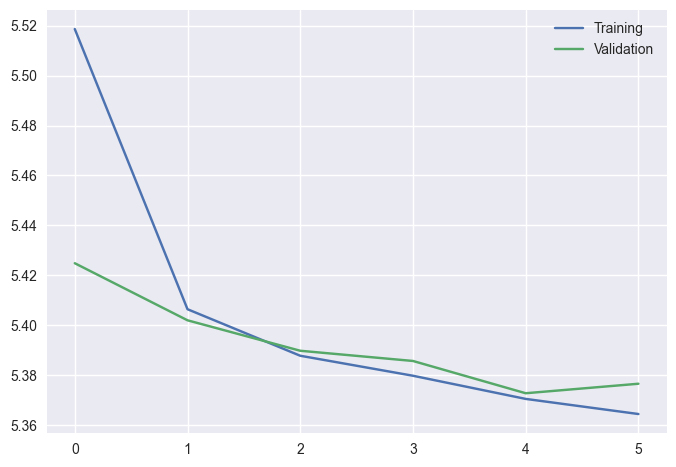

Training Time: 40.92 minutes


In [29]:
EPOCHS = 12
LEARNING_RATE = 4e-5
CLIP_VALUE = 0.7

# Instaniate the model
seedTorch()
model = BERT_SPAN(bert_model=BERT_MODEL, vocab_size=len(relation_vocab)).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE)
scheduler = get_linear_schedule_with_warmup(optimizer, 0, len(train_dataloader)*EPOCHS)
lossfunc = nn.CrossEntropyLoss()

# Train the model
start_time = time.time()
model = optimize_model_span(EPOCHS,optimizer, scheduler, train_dataloader, val_dataloader, lossfunc, model, device, True, CLIP_VALUE)
print(f'Training Time: {(time.time() - start_time)/60:.2f} minutes')

The early stopping technique was effective in preventing overfitting as the model stopped training after 5 epochs, which was when it started to overfit based on the learning curve. From the first epoch, the performance on the validation set was great and kept improving until that point. 

Although the accuracy metric is slightly lower, it may not be the best metric to evaluate performance in this case. The F1-score showed that the model had good recall for identifying entity spans but also highlighted the importance of having high precision to avoid false positives. Then I evaluate on the test set.

In [31]:
# Load the best model found before
seedTorch()
model = BERT_SPAN(bert_model=BERT_MODEL, vocab_size=len(relation_vocab)).to(device)
model.load_state_dict(torch.load('./best_span_model.pt'))

# Evaluate on the test set
lossfunc = nn.CrossEntropyLoss()
_ = evaluation_function_span(dataloader=test_dataloader, model=model, lossfunc=lossfunc, device=device,display=True)


Evaluation Results
_________________________________

Mean Loss: 5.38 
Precision: 86.24%
Recall: 88.83%
Span Entity Accuracy : 78.03%
Average F1-Score: 87.15%
Dataset Wide F1*: 87.52%
_________________________________


On the test set, the model showed similar performance, indicating that it had learned to identify entity spans effectively. This suggests that the model is likely to generalize well to new, unseen data.

For the metrics to get a better understanding of the model's performance, TP, FP and FN counts were computed for each span and I used these to calculate them instead of using a library. The span entity accuracy may not be very high, but the Dataset Wide F1-Score suggested in the paper was used to take into account the overall performance of the model across the entire dataset. This score considers the performance of the model across all spans in the dataset and the 87.5% score is great considering the small size used for training.

### Relation Prediction Model Training

For the Relation model I use the cross-entropy loss function as well, the AdamW optimizer and linear scheduler with warm-up. For evaluation I use the accuracy metric as suggested in the paper.


Epoch 1
_________________________________
loss: 4.829383  [    0/19463]
loss: 4.597147  [ 2048/19463]
loss: 4.616722  [ 4096/19463]
loss: 4.586152  [ 6144/19463]
loss: 4.405441  [ 8192/19463]
loss: 4.470374  [10240/19463]
loss: 4.221172  [12288/19463]
loss: 4.312935  [14336/19463]
loss: 4.242733  [16384/19463]
loss: 4.250407  [18432/19463]

Evaluation Results
_________________________________
Predicted 1760 / 2818 correctly
Mean Loss: 4.22 
Accuracy : 62.46%
_________________________________
_________________________________

Epoch 2
_________________________________
loss: 4.196793  [    0/19463]
loss: 4.094087  [ 2048/19463]
loss: 4.374843  [ 4096/19463]
loss: 4.123100  [ 6144/19463]
loss: 4.187867  [ 8192/19463]
loss: 4.306762  [10240/19463]
loss: 4.186307  [12288/19463]
loss: 4.193840  [14336/19463]
loss: 4.247129  [16384/19463]
loss: 4.372975  [18432/19463]

Evaluation Results
_________________________________
Predicted 1975 / 2818 correctly
Mean Loss: 4.14 
Accuracy : 70.09%
____

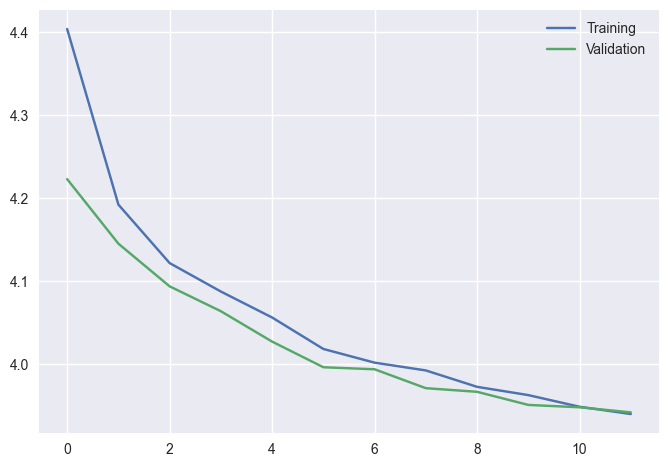

Training Time: 50.87 minutes


In [23]:
EPOCHS = 12
LEARNING_RATE = 4e-5
CLIP_VALUE = 0.7

# Instaniate the model
seedTorch()
model = BERT_REL(bert_model=BERT_MODEL, vocab_size=len(relation_vocab)).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE)
scheduler = get_linear_schedule_with_warmup(optimizer, 0, len(train_dataloader)*EPOCHS)
lossfunc = nn.CrossEntropyLoss()

# Train the model
start_time = time.time()
model = optimize_model_relation(EPOCHS,optimizer, scheduler, train_dataloader, val_dataloader, lossfunc, model, device, True, CLIP_VALUE)
print(f'Training Time: {(time.time() - start_time)/60:.2f} minutes')

The relation prediction model showed excellent performance, improving steadily from 62.46% accuracy after the first epoch to 90.35% accuracy after twelve epochs, without overfitting as indicated by the learning curve. 

This performance shows that when trained on its own the relation prediction model using BERT and a linear layer is able to learn and perform well in classifying the relation in a question. Finally, evaluating on the test set to fully assess the model's generalizability.

In [24]:
# Evaluate on the test set
lossfunc = nn.CrossEntropyLoss()
_ = evaluation_function_relation(dataloader=test_dataloader, model=model, lossfunc=lossfunc, device=device,display=True)


Evaluation Results
_________________________________
Predicted 4973 / 5616 correctly
Mean Loss: 3.96 
Accuracy : 88.55%
_________________________________


On the test as well the performance is great scoring over 88% accuracy. Interestingly, the relation prediction model required twelve epochs to achieve the best performance, while the span entity prediction model required only five epochs. This suggests that the two models needed to learn different traits and that it was not possible to achieve optimal performance for both tasks with the same set of parameters in a single model.

In conclusion, both the span and relation prediction models showed excellent performance, with the span prediction model achieving 87.52% dataset wide F1-score on the test set and the relation prediction model achieving 88.55% accuracy on the same set. The generalizability of the models to unseen data was also great. This training showed promising results for both models that will be used for the question answering enging where new questions will be asked in natural language by the user.